In [1]:
%config Completer.use_jedi = False
%config IPCompleter.greedy=True


In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import nibabel as nib
import os
import pandas as pd
import pydicom
from niwidgets import NiftiWidget
import imageio
from PIL import Image
import cv2
from pathlib import Path
import glob
from sklearn.model_selection import train_test_split
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
%matplotlib inline


ModuleNotFoundError: No module named 'pydicom'

In [48]:
BASE_PATH = Path('G:\ML Project Datasets\Medical Image\MM-WH 2017 Dataset')
LABELS_TO_KEEP=[1,600,420,550,205]

In [4]:

def normalize(data):
    data=(data-np.min(data))/(np.max(data)-np.min(data))
    return data
def load_case(image_nifty_file, label_nifty_file):
    # load the image and label file, get the image content and return a numpy array for each
    image = np.array(nib.load(image_nifty_file).get_fdata())
    label = np.array(nib.load(label_nifty_file).get_fdata())
#     image=normalize(image)
    return image, label

In [10]:
def convert_labels(label_volume):
    new_labels=np.zeros(label_volume.shape)
    for lbl in np.unique(label_volume):
        if lbl in LABELS_TO_KEEP:
            new_labels[np.where(label_volume==lbl)]=1
    return new_labels
        


In [49]:
image, label = load_case(BASE_PATH/'volumes'/'ct_train_1001_image.nii.gz',BASE_PATH/'labels'/'ct_train_1001_label.nii.gz')
new_label=convert_labels(label)

In [58]:
bins = np.linspace(-3000, 3000, 200)

In [59]:
np.max(image)

3482.0

In [72]:
image1, label1 = load_case(BASE_PATH/'volumes'/'mouse_image.nii',BASE_PATH/'labels'/'mouse_label.nii.gz')
image2, label2 = load_case(BASE_PATH/'volumes'/'ct_train_1002_image.nii.gz',BASE_PATH/'labels'/'ct_train_1002_label.nii.gz')
label1=convert_labels(label1)
label2=convert_labels(label2)
p1=(image1)[label1==1]
p2=(image2)[label2==1]

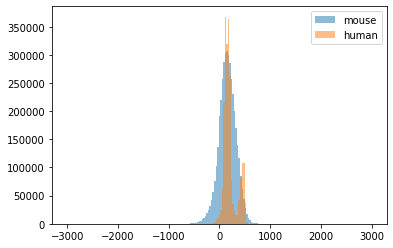

In [73]:
plt.hist(list(p1),bins, alpha=0.5, label='mouse')
plt.hist(list(p2),bins, alpha=0.5, label='human')
plt.legend(loc='upper right')
plt.show()

In [6]:
image=normalize(image)

In [9]:
# visualization functions
def explore_3dimage(layer):
    plt.figure(figsize=(20, 10))
#     plt.subplot(1, 2, 1)
    plt.imshow(draw_mask(image[:, layer,:],new_label[:,layer,:]));
#     plt.subplot(1, 2, 2)
#     plt.imshow(image[:, layer,:], cmap='gray');
#     plt.title('Explore Layers of Brain MRI', fontsize=20)
    plt.axis('off')
    return layer
def draw_mask(image,mask=None):
   
    rgb=np.zeros([image.shape[0],image.shape[1],3])
    rgb[:,:,0]=image
    rgb[:,:,1]=image
    rgb[:,:,2]=image
    
    rgb[np.where(mask==1)]=(0,255,255)
    
#     rgb = imageio.segmentation.mark_boundaries(rgb, mask, mode='thick',color=(0,0,1))
#     rgb = segmentation.mark_boundaries(rgb, tumor, mode='thick',color=(1,0,0))
#     rgb=rgb*255
#     rgb=rgb.astype(np.uint8)
    return rgb
def make_plots(images,masks=None):
    """PLot images in one row."""
    n = len(images)
    
    plt.figure(figsize=(20, 10))

    for i, (image) in enumerate(images):
        plt.subplot(1, n*2, i + 1)
        plt.xticks([])
        plt.yticks([])
        if masks is not None:
            rgb=draw_mask(image,masks[i])
            print(rgb.shape)
        else:
            rgb=image
        plt.imshow(rgb,cmap="gray")

    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(512, 363, 3)


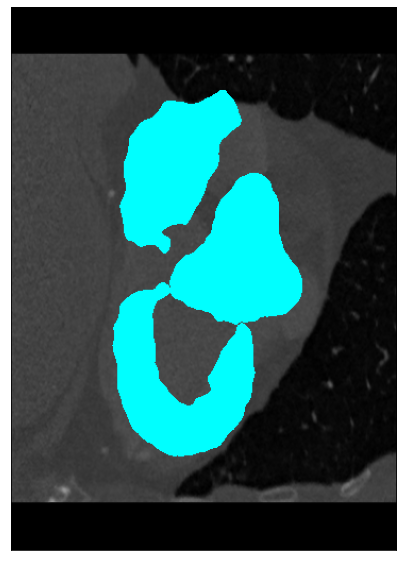

In [11]:
make_plots([image[:,400,:]],[new_label[:,255,:]])

In [12]:

# Run the ipywidgets interact() function to explore the data

interact(explore_3dimage, layer=(0, image.shape[1] - 1));

interactive(children=(IntSlider(value=255, description='layer', max=511), Output()), _dom_classes=('widget-int…

In [13]:
# Testing new labels output mesh
a=nib.load(BASE_PATH/'labels'/'ct_train_1001_label.nii.gz')
H,W,D=new_label.shape
layers=new_label.copy()
layers[H-int(H/3):,:,:]=0
ni_img = nib.Nifti1Image(layers,a.affine)
nib.save(ni_img, 'output.nii.gz')

In [14]:
# Generating 2d 
DATASET_2D_BASE_PATH=Path('G:\ML Project Datasets\Medical Image\MM-WH 2017 Dataset\Axials Version')


In [15]:
def make_dir(path):
    if os.path.exists==False:
        os.mkdir(path)


In [16]:
# test train split of volumes
train_vol,test_vol=train_test_split(os.listdir(BASE_PATH/'volumes'),test_size=0.2,random_state=5)

In [17]:
test_vol

['ct_train_1003_image.nii.gz',
 'ct_train_1018_image.nii.gz',
 'ct_train_1020_image.nii.gz',
 'mouse_image.nii',
 'ct_train_1019_image.nii.gz']

In [18]:
def standardize(image):
    centered = image-np.mean(image)
    if np.std(centered) != 0:
        centered = centered/np.std(centered)
    return centered
def convert_2d(volumes,destination_path):
    make_dir(destination_path)
    for volume_name in list(volumes):
        print(volume_name)
        volume_label_name = volume_name.replace('image',"label")
        volume_image, volume_label = load_case(BASE_PATH/'volumes'/volume_name,BASE_PATH/'labels'/volume_label_name)
        volume_label = convert_labels(volume_label)
        H,W,D=volume_image.shape
        print(H,W,D)
        
        volume_name=volume_name.split(".")[0]
        volume_label_name=volume_label_name.split(".")[0]
        for i in range(H):
            img=normalize(volume_image[i,:,:])
            img = img*255
            img =img.astype('uint8')
            cv2.imwrite(os.path.join(destination_path,'images',volume_name+"_Sagital_"+str(i)+".png"),img)
            cv2.imwrite(os.path.join(destination_path,'masks',volume_name+"_Sagital_"+str(i)+".png"),volume_label[i,:,:])
        for i in range(W):
            img=normalize(volume_image[:,i,:])
            img = img*255
            img =img.astype('uint8')
            cv2.imwrite(os.path.join(destination_path,'images',volume_name+"_Coronal_"+str(i)+".png"),img)
            cv2.imwrite(os.path.join(destination_path,'masks',volume_name+"_Coronal_"+str(i)+".png"),volume_label[:,i,:])
        
        for i in range(D):
            img=normalize(volume_image[:,:,i])
            img = img*255
            img =img.astype('uint8')
            cv2.imwrite(os.path.join(destination_path,'images',volume_name+"_Transversal_"+str(i)+".png"),img)
            cv2.imwrite(os.path.join(destination_path,'masks',volume_name+"_Transversal_"+str(i)+".png"),volume_label[:,:,i])

        

In [33]:
# training axials
convert_2d(train_vol,DATASET_2D_BASE_PATH/'train')

ct_train_1013_image.nii.gz
512 512 211
ct_train_1002_image.nii.gz
512 512 239
ct_train_1012_image.nii.gz
512 512 177


g:\projects and work\mouse heart segmentation\venv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


ct_train_1011_image.nii.gz
512 512 239
ct_train_1014_image.nii.gz
512 512 358


g:\projects and work\mouse heart segmentation\venv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


ct_train_1019_image.nii.gz
512 512 297


g:\projects and work\mouse heart segmentation\venv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


ct_train_1008_image.nii.gz
512 512 222
ct_train_1005_image.nii.gz
512 512 177


g:\projects and work\mouse heart segmentation\venv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


ct_train_1009_image.nii.gz
512 512 293
ct_train_1010_image.nii.gz
512 512 274


g:\projects and work\mouse heart segmentation\venv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


ct_train_1001_image.nii.gz
512 512 363


g:\projects and work\mouse heart segmentation\venv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


ct_train_1017_image.nii.gz
512 512 283


g:\projects and work\mouse heart segmentation\venv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


ct_train_1007_image.nii.gz
512 512 243
ct_train_1016_image.nii.gz
512 512 333


g:\projects and work\mouse heart segmentation\venv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


ct_train_1015_image.nii.gz
512 512 300


g:\projects and work\mouse heart segmentation\venv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


ct_train_1004_image.nii.gz
512 512 200


In [12]:
# validation axials
convert_2d(test_vol,DATASET_2D_BASE_PATH/'val')

ct_train_1003_image.nii.gz
512 512 298


g:\projects and work\mouse heart segmentation\venv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


ct_train_1006_image.nii.gz
512 512 248
ct_train_1018_image.nii.gz
512 512 187
ct_train_1020_image.nii.gz
512 512 363


g:\projects and work\mouse heart segmentation\venv\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


20593

<BarContainer object of 2 artists>

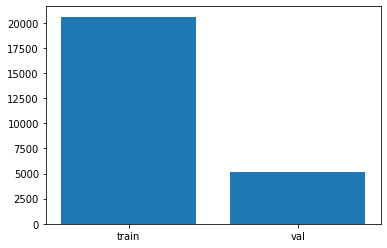

In [25]:
plt.bar(['train','val'],[len(os.listdir(DATASET_2D_BASE_PATH/'train'/'images')),len(os.listdir(DATASET_2D_BASE_PATH/'val'/'images'))])